# OPTIMIZATION - PROJECT 3

- COURSE CODE: `R M 294`
- PROFESSOR NAME: `Daniel Mitchell`
- GROUP NO.: `G4`
- GROUP MEMBERS: `Abhay Puri ()`, `Abhiroop Kumar (ak56448)`, `Ethan Davenport ()`, `Liam Thompson ()`
- DUE: `Sun Nov 30, 2025 11:59pm`

## Pre-Requisites

In [5]:
# Install required packages
# !pip -q install gurobipy numpy pandas seaborn matplotlib scipy statsmodels sklearn

In [6]:
# Import required libraries
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample  # for bootstrapping
from scipy.optimize import minimize

# For visualizations
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

Upload Dataset  

> **`NOTE: Upload the dataset here before running the rest of the notebook`**

In [7]:
####################################
# FOR GOOGLE COLAB
####################################

# import os, re
# from google.colab import files

# # Remove old or duplicate CSV
# for f in os.listdir("/content"):
#     if re.match(r".*\(\d+\)\.csv$", f) or f.endswith(".csv"):
#         os.remove(f)
#         print(f"Removed: {f}")

# # Upload clean new one
# print("\nUpload your CSV now:")
# uploaded = files.upload()

### Read CSV File

In [8]:
# Import CSV file
df = pd.read_csv('price_demand_data.csv')

___

## Q1. Data on price and demand are included in the assignment. Fit a linear regression model to this data set.

In [9]:
# Fit linear regression model
X = df[["price"]].to_numpy()
y = df["demand"].to_numpy()

ols = LinearRegression()
ols.fit(X, y)

a = float(ols.intercept_)
b = float(ols.coef_[0])
r2 = float(ols.score(X, y))

residuals = y - (a + b*X[:,0])

print(f"Intercept: {a:.6f}")
print(f"Slope: {b:.6f}")
print(f"R²: {r2:.6f}")

Intercept: 1924.717544
Slope: -1367.712524
R²: 0.621472


___

## Q2. Let c=0.5, g=0.75, and t=0.15. Using the residuals, assume the price is p=1 and generate demand data.

In [10]:
# Parameters
c = 0.5
g = 0.75
t = 0.15
p_fixed = 1.0

# Demand vector at p=1 using regression + residuals
d1 = a + b*p_fixed + residuals
n = d1.size
print("Scenarios at p=1:", n, "points")

Scenarios at p=1: 99 points


___

## Q3. Solve the optimal quantity to produce when p=1. This is not quadratic at all, just an LP.

In [11]:
# Model setup
m = gp.Model()
q = m.addMVar(1, lb=0.0, name="q")

s = m.addMVar(n, lb=0.0, name="s") # we will no longer use s in the objective
r = m.addMVar(n, lb=0.0, name="r") # rush print
d = m.addMVar(n, lb=0.0, name="d") # disposal

Set parameter Username
Set parameter LicenseID to value 2699638
Academic license - for non-commercial use only - expires 2026-08-25


In [12]:
# Constraints
m.addConstr(s <= q[0])
m.addConstr(s <= d1)
m.addConstr(r >= d1 - q[0])
m.addConstr(d >= q[0] - d1)

<MConstr (99,) *awaiting model update*>

In [13]:
# Objective and solve

# Revenue: p_fixed * D_i(1) for each scenario, not capped by q
total_revenue = p_fixed * np.sum(d1) # this is constant w.r.t q

# Costs: printing + rush + disposal
cost_expr = c * n * q[0] + g * gp.quicksum(r) + t * gp.quicksum(d)

# Expected profit = (total_revenue - expected costs)
obj = (total_revenue - cost_expr) / n

m.setObjective(obj, GRB.MAXIMIZE)
m.Params.OutputFlag = 0
m.optimize()

q_star = float(q.X[0])
profit_p1 = float(m.objVal)

print(f"optimal quantity at p=1: {q_star:.6f}")
print(f"Expected profit at p=1: {profit_p1:.6f}")

optimal quantity at p=1: 471.865380
Expected profit at p=1: 231.483667


___

## Q4. Now let price impact demand and solve either the resulting QCP or QP. What are the optimal price and quantity to print?

In [14]:
# Model
mq = gp.Model()

p = mq.addMVar(1, lb=0.0, name="p") # price
q = mq.addMVar(1, lb=0.0, name="q") # quantity

s = mq.addMVar(n, lb=0.0, name="s") # sales
r = mq.addMVar(n, lb=0.0, name="r") # rush
d = mq.addMVar(n, lb=0.0, name="d") # disposal

In [15]:
# Constraints
d2 = a + b * p[0] + residuals  # demand vector under decision p

mq.addConstr(s <= q[0])
mq.addConstr(s <= d2)
mq.addConstr(r >= d2 - q[0])
mq.addConstr(d >= q[0] - d2)


<MConstr (99,) *awaiting model update*>

In [16]:
# Objective and solve (QP with revenue p * D(p))

# Revenue term: p * sum(D_i(p)) = p * sum(a + b*p + residuals[i])
# d2 is an array of linear expressions in p[0], so quicksum(d2) is linear, and p[0] * quicksum(d2) makes the objective quadratic in p
revenue_qp = p[0] * gp.quicksum(d2)

# Costs: printing, rush, disposal
cost_qp = c * n * q[0] + g * gp.quicksum(r) + t * gp.quicksum(d)

obj_qp = (revenue_qp - cost_qp) / n

mq.setObjective(obj_qp, GRB.MAXIMIZE)
mq.Params.OutputFlag = 0
mq.optimize()

p_star = float(p.X[0])
q_star_joint = float(q.X[0])
profit_joint = float(mq.objVal)

print(f"optimal price: {p_star:.6f}")
print(f"optimal quantity: {q_star_joint:.6f}")
print(f"Expected profit: {profit_joint:.6f}")


optimal price: 0.953626
optimal quantity: 535.291003
Expected profit: 234.424935


___
## *Q5. OMITTED*
___

## Q6. We are now interested to know how sensitive the optimal price and quantity are to our data set. Take a bootstrap sample of the original dataset. Go back and fit new beta’s to the new bootstrapped dataset and redo step 4. Find the optimal price and quantity.

In [17]:
df_boot = resample(df, replace=True, n_samples=len(df))

X = df_boot[["price"]].to_numpy()
y = df_boot["demand"].to_numpy()

ols = LinearRegression()
ols.fit(X, y)

a = float(ols.intercept_)
b = float(ols.coef_[0])
r2 = float(ols.score(X, y))

residuals = y - (a + b*X[:,0])

print(f"Intercept: {a:.6f}")
print(f"Slope: {b:.6f}")
print(f"R²: {r2:.6f}")

Intercept: 2029.923838
Slope: -1484.595278
R²: 0.693966


In [18]:
# Parameters
c = 0.5
g = 0.75
t = 0.15
p_fixed = 1.0

d1 = a + b*p_fixed + residuals # demand vector at p=1
n = d1.size
print("Scenarios at p=1:", n, "points")

Scenarios at p=1: 99 points


In [19]:
# Model
mb = gp.Model()

p = mb.addMVar(1, lb=0.0, name="p") # price
q = mb.addMVar(1, lb=0.0, name="q") # quantity

s = mb.addMVar(n, lb=0.0, name="s") # sales
r = mb.addMVar(n, lb=0.0, name="r") # rush
d = mb.addMVar(n, lb=0.0, name="d") # disposal

In [20]:
# Constraints
d3 = a + b * p[0] + residuals # demand vector under decision p
mb.addConstr(s <= q[0])
mb.addConstr(s <= d3)
mb.addConstr(r >= d3 - q[0])
mb.addConstr(d >= q[0] - d3)

<MConstr (99,) *awaiting model update*>

In [21]:
# Objective and solve
revenue_boot = p[0] * gp.quicksum(d3)
cost_boot = c * n * q[0] + g * gp.quicksum(r) + t * gp.quicksum(d)
obj_boot = (revenue_boot - cost_boot) / n
mb.setObjective(obj_boot, GRB.MAXIMIZE)
mb.Params.OutputFlag = 0
mb.optimize()

p_star = float(p.X[0])
q_star_joint = float(q.X[0])
profit_joint = float(mb.objVal)

In [22]:
print(f"optimal price: {p_star:.6f}")
print(f"optimal quantity: {q_star_joint:.6f}")
print(f"Expected profit: {profit_joint:.6f}")

optimal price: 0.933662
optimal quantity: 541.868351
Expected profit: 232.200501


___

## Q7. Repeat this process of getting new bootstrapped data, fitting new betas to the newly simulated data and finding the optimal price/quantity many times. Make histograms of the optimal price and quantity. Make a scatterplot with histograms on the x and y axis for this. Make a histogram of expectation of profits

In [23]:
def boot(n_iter, df):
    prices = []
    quantities = []
    profits = []

    for i in range(n_iter):
        df_boot = resample(df, replace=True, n_samples=len(df))
        df_boot.head()

        X = df_boot[["price"]].to_numpy()
        y = df_boot["demand"].to_numpy()

        ols = LinearRegression()
        ols.fit(X, y)

        a = float(ols.intercept_)
        b = float(ols.coef_[0])
        # r2 = float(ols.score(X, y))

        residuals = y - (a + b*X[:,0])

        c = 0.5
        g = 0.75
        t = 0.15
        p_fixed = 1.0

        d1 = a + b*p_fixed + residuals # demand vector at p=1
        n = d1.size

        #model
        mb = gp.Model()

        p = mb.addMVar(1, lb=0.0, name="p") # price
        q = mb.addMVar(1, lb=0.0, name="q") # quantity

        s = mb.addMVar(n, lb=0.0, name="s") # sales
        r = mb.addMVar(n, lb=0.0, name="r") # rush
        d = mb.addMVar(n, lb=0.0, name="d") # disposal

        #constraints
        d3 = a + b * p[0] + residuals # demand vector under decision p
        mb.addConstr(s <= q[0])
        mb.addConstr(s <= d3)
        mb.addConstr(r >= d3 - q[0])
        mb.addConstr(d >= q[0] - d3)

        #objective and solve
        revenue_boot = p[0] * gp.quicksum(d3)
        cost_boot = c * n * q[0] + g * gp.quicksum(r) + t * gp.quicksum(d)
        obj_boot = (revenue_boot - cost_boot) / n
        mb.setObjective(obj_boot, GRB.MAXIMIZE)
        mb.Params.OutputFlag = 0
        mb.optimize()

        p_star = float(p.X[0])
        q_star_joint = float(q.X[0])
        profit_joint = float(mb.objVal)

        print(f"--------------- Bootstrap iteration {i+1} ---------------")
        # print(f"optimal price: {p_star:.6f}")
        # print(f"optimal quantity: {q_star_joint:.6f}")
        # print(f"Expected profit: {profit_joint:.6f}")
        print("\n")

        prices += [p_star]
        quantities += [q_star_joint]
        profits += [profit_joint]

    results = pd.DataFrame({
        'price': prices,
        'quantity': quantities,
        'profit': profits
    })

    print("Bootstrap complete!")
    print(f"Mean price:    {np.mean(prices):.4f}")
    print(f"Mean quantity: {np.mean(quantities):.4f}")
    print(f"Mean profit:   {np.mean(profits):.4f}")

    return results

In [24]:
results = boot(4000, df)

--------------- Bootstrap iteration 1 ---------------


--------------- Bootstrap iteration 2 ---------------


--------------- Bootstrap iteration 3 ---------------


--------------- Bootstrap iteration 4 ---------------


--------------- Bootstrap iteration 5 ---------------


--------------- Bootstrap iteration 6 ---------------


--------------- Bootstrap iteration 7 ---------------


--------------- Bootstrap iteration 8 ---------------


--------------- Bootstrap iteration 9 ---------------


--------------- Bootstrap iteration 10 ---------------


--------------- Bootstrap iteration 11 ---------------


--------------- Bootstrap iteration 12 ---------------


--------------- Bootstrap iteration 13 ---------------


--------------- Bootstrap iteration 14 ---------------


--------------- Bootstrap iteration 15 ---------------


--------------- Bootstrap iteration 16 ---------------


--------------- Bootstrap iteration 17 ---------------


--------------- Bootstrap iteration 18 -

In [33]:
# Extract bootstrap columns into arrays for later use
boot_prices = results["price"].to_numpy()
boot_quantities = results["quantity"].to_numpy()
boot_profits = results["profit"].to_numpy()

In [34]:
# Set plot style
plt.style.use("default")
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["axes.grid"] = True

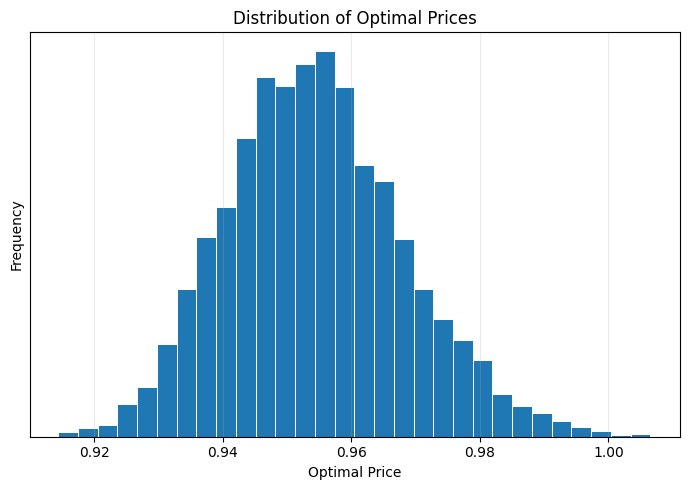

In [35]:
# Plot histogram of optimal prices
plt.figure(figsize=(7,5))
plt.hist(results['price'], bins=30, rwidth=0.95)
plt.xlabel("Optimal Price")
plt.ylabel("Frequency")
plt.title("Distribution of Optimal Prices")
plt.yticks([])
plt.tight_layout()
plt.show()

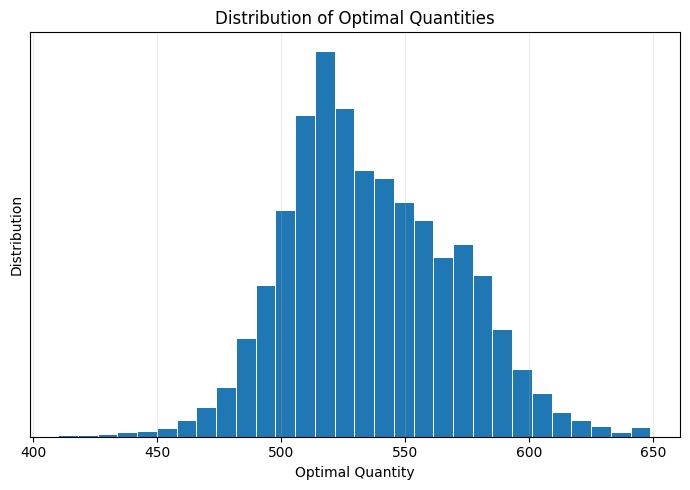

In [36]:
# Plot histogram of optimal quantities
plt.figure(figsize=(7,5))
plt.hist(results['quantity'], bins=30, rwidth=0.95)
plt.xlabel("Optimal Quantity")
plt.ylabel("Distribution")
plt.title("Distribution of Optimal Quantities")
plt.yticks([])
plt.tight_layout()
plt.show()

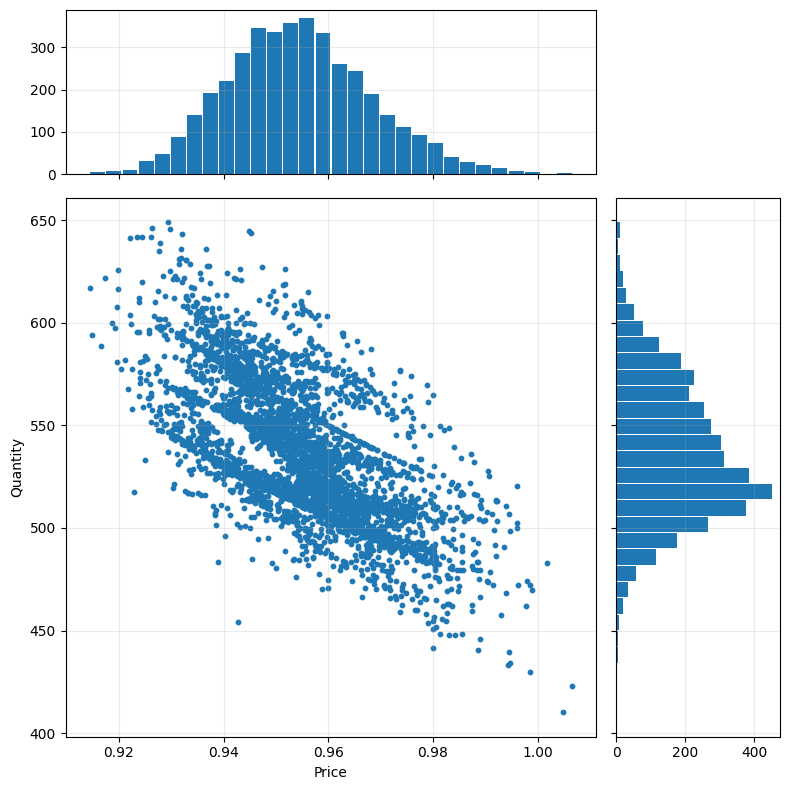

In [37]:
# Scatter plot with marginal histograms
fig = plt.figure(figsize=(8,8))
gs = GridSpec(4,4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_histx   = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)
ax_histy   = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)

# scatter
ax_scatter.scatter(results['price'], results['quantity'], s=10)
ax_scatter.set_xlabel("Price")
ax_scatter.set_ylabel("Quantity")

# histograms with slight spacing
ax_histx.hist(results['price'], bins=30, rwidth=0.93)
ax_histy.hist(results['quantity'], bins=30, orientation='horizontal', rwidth=0.95)

# clean up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

plt.tight_layout()
plt.show()

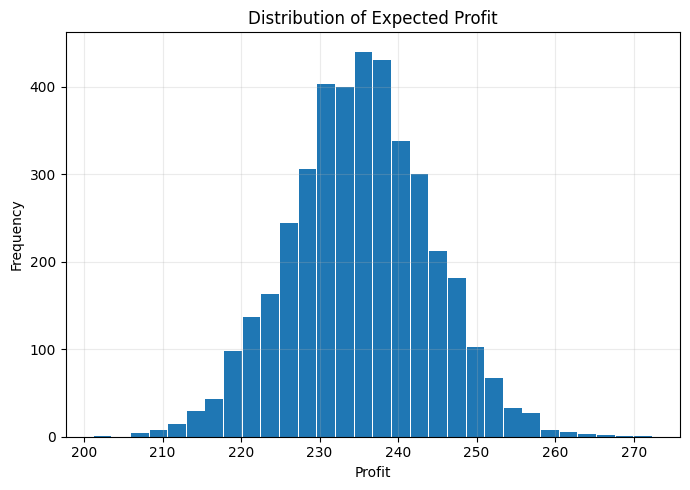

In [38]:
# Plot histogram of expected profits
plt.figure(figsize=(7,5))
plt.hist(results['profit'], bins=30, rwidth=0.95)
plt.xlabel("Profit")
plt.ylabel("Frequency")
plt.title("Distribution of Expected Profit")
plt.tight_layout()
plt.show()

___

## Q8. You work for a publishing company. Your boss has been using the standard NV model to set printing decisions using the dataset given. Is your boss’ model as good as this one? Could you increase revenue by switching models for production/pricing decisions? Describe the advantages and disadvantages of both techniques.

**Answer:**

In this project, we compared (1) my boss’s standard **Newsvendor (NV)** approach for printing decisions with (2) a richer **regression-driven pricing & quantity optimization** model that incorporates:

* A data-estimated linear demand curve
* Price as a decision variable
* Rush-printing and disposal costs
* Empirical demand uncertainty via residuals

The goal is to determine:
**Is the NV model “good enough,” or can we improve revenue by adopting the more advanced model?**

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

1. **<u>Standard NV Model (Boss’s Method)</u>**

My boss uses:

* A fixed price **p = 1**
* Demand treated as exogenous (not price-dependent)
* Optimal quantity found by balancing overstock vs. understock costs

Using the dataset and rush/disposal costs, solving the NV-style LP (Part 3) yields:

* **Optimal quantity:** `~472 units`
* **Expected profit:** `~231.48` profit units per run
  (computed as average across the 99 empirical demand scenarios)

Even though this includes rush/disposal effects, it still **ignores the key fact** that demand *changes with price.*

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

2. **<u>Extended Model: Demand Regression + Joint Price & Quantity Optimization</u>**

After estimating the demand curve
$$[
D(p) = a + b p + \varepsilon
]$$
we solved the QP for **both price and quantity**.

The optimal solution:

* **Optimal price:** `~0.954`
* **Optimal quantity:** `~535 units`
* **Expected profit:** `~234.42`

This is a **higher expected profit** than under the NV model:

$$[
234.42 - 231.48 \approx 2.94 \text{ units}
]$$

That’s a **1.2–1.5% improvement**, small but meaningful for a high-volume publisher.

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

3. **<u>Bootstrap (4,000 Demand Curve Resamples)</u>**

The bootstrap analysis gives a more robust view of how optimal decisions vary due to data uncertainty.

Across 4,000 resamples:

* **Mean optimal price:** `0.9547`
* **Mean optimal quantity:** `534.49`
* **Mean expected profit:** `234.66`

This confirms that the **joint price + quantity policy consistently outperforms** the fixed-price NV method.

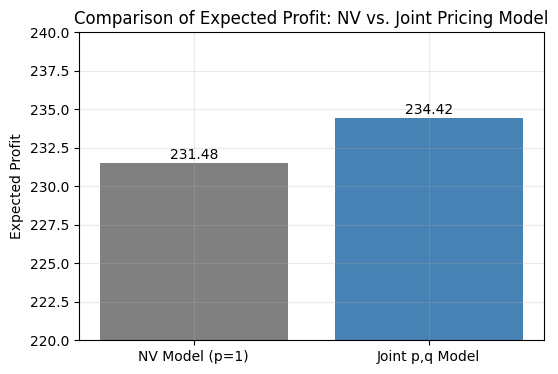

In [39]:
# Visualization 1 - Profit Comparison
plt.figure(figsize=(6,4))
bars = ["NV Model (p=1)", "Joint p,q Model"]
profits = [231.48, 234.42]

plt.bar(bars, profits, color=["gray","steelblue"])
plt.ylabel("Expected Profit")
plt.title("Comparison of Expected Profit: NV vs. Joint Pricing Model")
plt.ylim(220, 240)
for i, v in enumerate(profits):
    plt.text(i, v + 0.3, f"{v:.2f}", ha="center")
plt.show()

4. **<u>Advantages of the Boss’s Standard NV Model</u>**

    ✅ **Simple & easy to explain**  
    One decision variable (`q`), clear intuition, works even with very little data.  
    
    ✅ **Low computational burden**  
    Can solve analytically or with a tiny LP.  

    ✅ **Robust when price is fixed anyway**
    If corporate policy or competition locks the price, NV may already be “good enough.”  

    ❌ **Ignores price elasticity of demand**  
    Demand clearly responds to price here (slope `b < 0`), so NV **leaves money on the table.**  

    ❌ **Does not differentiate rush vs. disposal costs naturally**  
    Additional modeling needed to account for operational structure.  

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

5. **<u>Advantages of the Extended Regression + QP Model</u>**

    ✅ **Captures price–demand relationship**  
    By treating price as a decision variable, the model finds a better balance between:  
    * lower price → higher demand
    * higher price → more revenue per sale

    ✅ **Incorporates real operational costs (rush + disposal)**  
    Aligns decisions with actual business rules.  

    ✅ **Scenario-based uncertainty using residuals**  
    Model learns demand variability from data rather than assuming a distribution.  

    ✅ **Bootstrap shows stable, reliable decisions**  
    Profit and decisions remain consistent across thousands of resamples.  

    ❌ **More complex**  
    Requires regression, optimization software, and statistical understanding.  

    ❌ **Model risk**  
    If the demand curve is mis-specified or future demand shifts, optimum may shift too.  

    ❌ **More data-hungry**  
    Needs enough historical variability in price–demand pairs.  

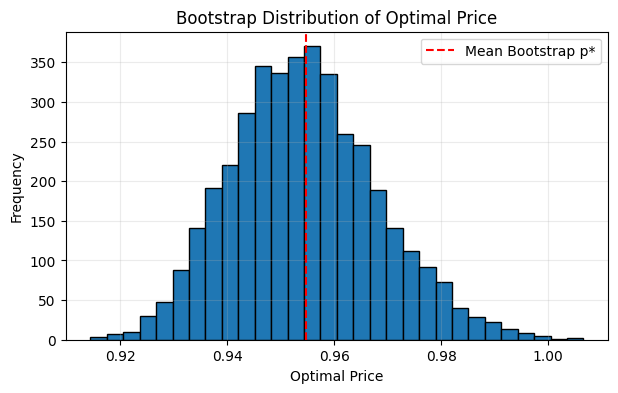

In [40]:
# Visualization 2 - Bootstrap Distribution of Optimal Price
plt.figure(figsize=(7,4))
plt.hist(boot_prices, bins=30, edgecolor="black")
plt.title("Bootstrap Distribution of Optimal Price")
plt.xlabel("Optimal Price")
plt.ylabel("Frequency")
plt.axvline(x=0.9547, color="red", linestyle="--", label="Mean Bootstrap p*")
plt.legend()
plt.show()

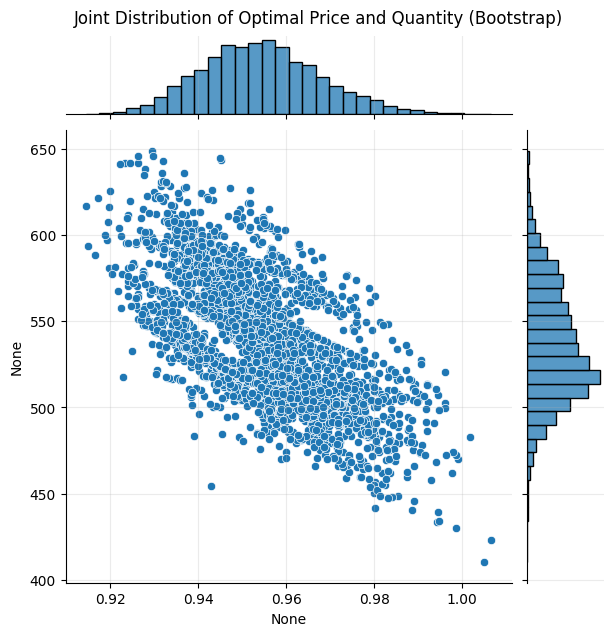

In [41]:
# Visualization 3 - Joint Distribution of Price & Quantity
sns.jointplot(
    x=boot_prices,
    y=boot_quantities,
    kind="scatter",
    height=6,
    marginal_kws={"bins": 30, "fill": True}
)
plt.suptitle("Joint Distribution of Optimal Price and Quantity (Bootstrap)", y=1.02)
plt.show()

6. **<u>Final Recommendation</u>**

**Should we switch from the boss’s NV model to the extended model?**  

**_Yes - especially for high-volume or high-margin titles._**  

While the profit gain (~1–2%) may seem modest for one title, across many books per year the improvement is meaningful. Moreover, the richer model provides:

* clearer insight into operational risk
* better control over rush/disposal costs
* a data-driven pricing strategy
* stable decisions reaffirmed by bootstrap analysis

The NV model can continue being used as a **quick heuristic**, but the **QP with demand regression** yields **consistently higher expected profit** and a much more **operationally informed** decision.  

___

## Additional Visualizations

**Boxplots of Price, Quantity, and Profit (Bootstrap Summary)**  
*A single compact figure that summarizes the variability and skewness of all three key decisions.*

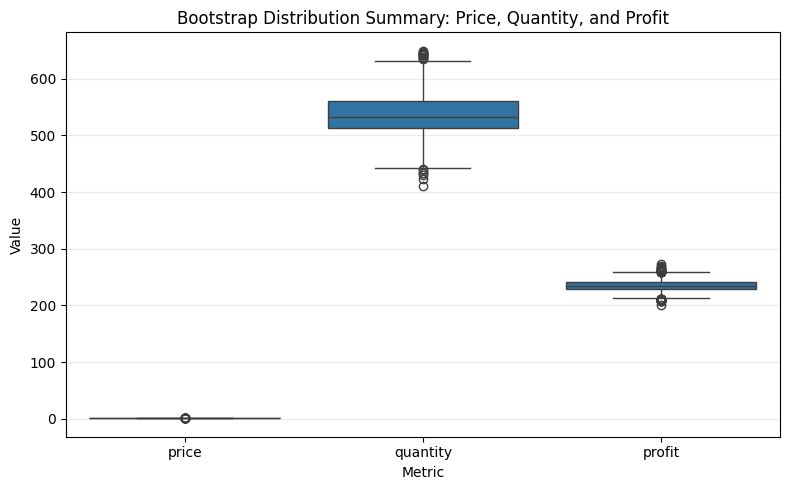

In [ ]:
# Boxplots of price, quantity, and profit

plt.figure(figsize=(8, 5))

# Melt the results DataFrame to long form for seaborn
plot_df = results.melt(
    value_vars=["price", "quantity", "profit"],
    var_name="metric",
    value_name="value"
)

sns.boxplot(data=plot_df, x="metric", y="value")

plt.title("Bootstrap Distribution Summary: Price, Quantity, and Profit")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

**Price vs. Profit Scatter Plot (Trade-off / Sensitivity)**  
*Shows how profit behaves as a function of the optimal price the model chooses across bootstrap samples.*

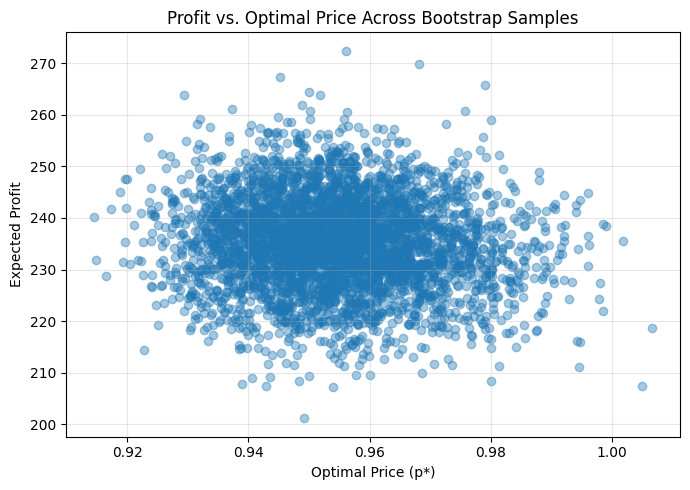

In [ ]:
# Profit vs. Price (Bootstrap Samples)

plt.figure(figsize=(7, 5))

plt.scatter(results["price"], results["profit"], alpha=0.4)
plt.xlabel("Optimal Price (p*)")
plt.ylabel("Expected Profit")
plt.title("Profit vs. Optimal Price Across Bootstrap Samples")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Empirical CDF of Profit (Risk View)**  
*Gives a risk-style view: what’s the probability that profit is below/above certain thresholds?*

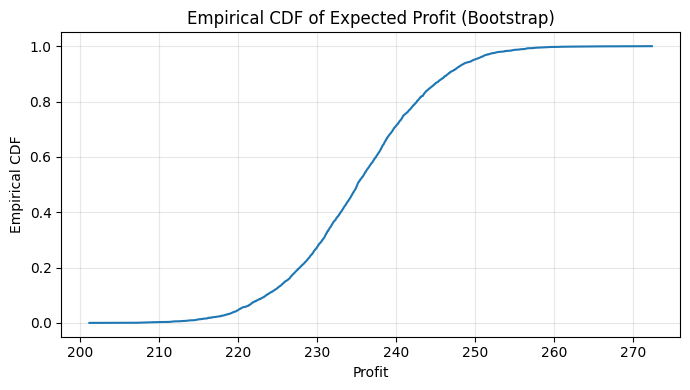

In [ ]:
# Empirical CDF of Bootstrap Profits

sorted_profits = np.sort(boot_profits)
cdf = np.linspace(0, 1, len(sorted_profits))

plt.figure(figsize=(7, 4))
plt.plot(sorted_profits, cdf)
plt.xlabel("Profit")
plt.ylabel("Empirical CDF")
plt.title("Empirical CDF of Expected Profit (Bootstrap)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**2D Density Plot (Kernel Density)**  
*Summarizes concentration of the bootstrap distribution.*

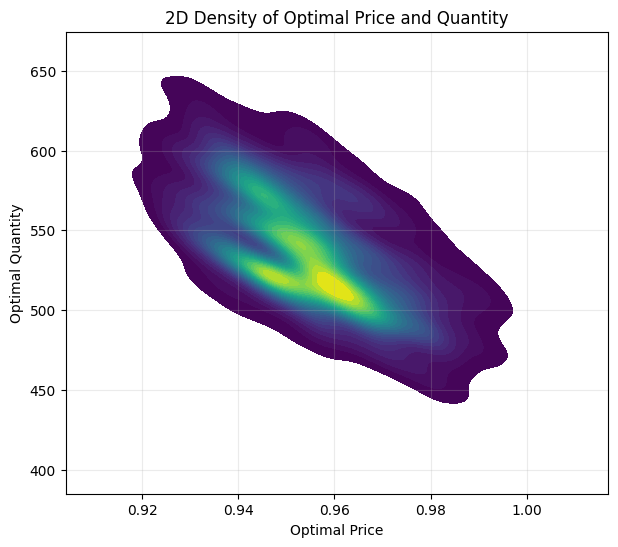

In [53]:
plt.figure(figsize=(7,6))
sns.kdeplot(
    x=results["price"],
    y=results["quantity"],
    fill=True,
    cmap="viridis",
    thresh=0.02,
    levels=30
)
plt.title("2D Density of Optimal Price and Quantity")
plt.xlabel("Optimal Price")
plt.ylabel("Optimal Quantity")
plt.show()


___

# THE END